In [55]:
# import torch
import json
import re
from pathlib import Path
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

table_path = Path("tables")
if not table_path.exists():
    table_path.mkdir(exist_ok=True)

sns.set_theme(
    context="notebook",
    style="ticks",
    font_scale=1.8,
    palette=None,
    rc={"figure.dpi": 300, "figure.constrained_layout.use": True, "lines.linewidth": 3, "figure.figsize": (6,3)},
)


## RoBERTa Base Results

In [56]:
# Table :
# Method | # params # SST-2 # MRPC # CoLA # QNLI # RTE # STS-B #

tab = [
    ["FT$^*$", "125M", 94.8, 90.2, 63.6, 92.8, 78.7, 91.2],
    ["BitFit$^*$", "0.1M", 93.7, 92.7, 62.0, 91.8, 81.5, 90.8],
    [
        "VeRA$^*$",
        "0.04M",
        "94.6±.1",
        "89.5±.5",
        "65.6±.8",
        "91.8±.2",
        "78.7±.7",
        "90.7±.2",
    ],
    [
        "LoRA$^*$",
        "0.3M",
        "95.1±.2",
        "89.7±.7",
        "63.4±1.2",
        "93.3±.3",
        "86.6±.7",
        "91.5±.2",
    ],
]

tab = pd.DataFrame(
    tab,
    columns=[
        "Method",
        "\# Trainable Params",
        "SST-2",
        "MRPC",
        "CoLA",
        "QNLI",
        "RTE",
        "STS-B",
    ],
)


tab["Average"] = (
    (tab.iloc[:, 2:].map(lambda x: float(x.split("±")[0]) if isinstance(x, str) else x))
    .mean(axis=1)
    .round(1)
)

display(tab)

tab_latex = (
    tab.map(str)
    .style.hide(level=0, axis=0)
    .highlight_max(axis=0, props="font-weight:bold")
    .to_latex(
        # position_float="centering",
        convert_css=True,
        hrules=True,
        # caption="Results on the GLUE benchmark for the RoBERTa-base model. Results derived from the original paper are indicated with asterisk.",
        # label="tab:glue_results_base",
        column_format="lcccccccc",
    )
)

tab_latex = tab_latex.replace("table", "table*").replace("±", r"\tiny ±")
with open(table_path / "glue_results_base.tex", "w") as f:
    f.write(tab_latex)
print(tab_latex)

,Method,\# Trainable Params,SST-2,MRPC,CoLA,QNLI,RTE,STS-B,Average
0,FT$^*$,125M,94.8,90.2,63.6,92.8,78.7,91.2,85.2
1,BitFit$^*$,0.1M,93.7,92.7,62.0,91.8,81.5,90.8,85.4
2,VeRA$^*$,0.04M,94.6±.1,89.5±.5,65.6±.8,91.8±.2,78.7±.7,90.7±.2,85.1
3,LoRA$^*$,0.3M,95.1±.2,89.7±.7,63.4±1.2,93.3±.3,86.6±.7,91.5±.2,86.6


\begin{tabular}{lcccccccc}
\toprule
Method & \# Trainable Params & SST-2 & MRPC & CoLA & QNLI & RTE & STS-B & Average \\
\midrule
FT$^*$ & \bfseries 125M & 94.8 & 90.2 & 63.6 & 92.8 & 78.7 & 91.2 & 85.2 \\
BitFit$^*$ & 0.1M & 93.7 & \bfseries 92.7 & 62.0 & 91.8 & 81.5 & 90.8 & 85.4 \\
\bfseries VeRA$^*$ & 0.04M & 94.6\tiny ±.1 & 89.5\tiny ±.5 & \bfseries 65.6\tiny ±.8 & 91.8\tiny ±.2 & 78.7\tiny ±.7 & 90.7\tiny ±.2 & 85.1 \\
LoRA$^*$ & 0.3M & \bfseries 95.1\tiny ±.2 & 89.7\tiny ±.7 & 63.4\tiny ±1.2 & \bfseries 93.3\tiny ±.3 & \bfseries 86.6\tiny ±.7 & \bfseries 91.5\tiny ±.2 & \bfseries 86.6 \\
\bottomrule
\end{tabular}



In [57]:
LoRA_paper = defaultdict(dict)
LoRA_paper['sst2'] = {'eval_accuracy' : 95.1/100}
LoRA_paper['mrpc'] = {'eval_accuracy' : 89.7/100}
LoRA_paper['cola'] = {'eval_matthews_correlation' : 63.4/100}
LoRA_paper['qnli'] = {'eval_accuracy' : 93.3/100}
LoRA_paper['rte'] = {'eval_accuracy' : 86.6/100}
LoRA_paper['stsb'] = {'eval_pearson' : 91.5/100}

VeRA_paper = defaultdict(dict)
VeRA_paper['sst2'] = {'eval_accuracy' : 94.6/100}
VeRA_paper['mrpc'] = {'eval_accuracy' : 89.5/100}
VeRA_paper['cola'] = {'eval_matthews_correlation' : 65.6/100}
VeRA_paper['qnli'] = {'eval_accuracy' : 91.8/100}
VeRA_paper['rte'] = {'eval_accuracy' : 78.7/100}
VeRA_paper['stsb'] = {'eval_pearson' : 90.7/100}

In [58]:
#DynaLoRA Periodic;50 random;16 target_modules=qv; everything else default from the original LoRA paper
#sst2 and qnli got interrupted but doesn't matter because the performance plateaued
dynalora_random_qv = defaultdict(dict)
dynalora_random_qv['sst2'] = {'eval_loss': 0.24287724494934082, 'eval_accuracy': 0.9357798165137615, 'eval_runtime': 1.1623, 'eval_samples_per_second': 750.217, 'eval_steps_per_second': 47.319, 'epoch': 14.0}
dynalora_random_qv['mrpc'] = {'eval_loss': 0.693554699420929, 'eval_accuracy': 0.8799019607843137, 'eval_f1': 0.9141856392294221, 'eval_runtime': 0.5891, 'eval_samples_per_second': 692.532, 'eval_steps_per_second': 44.132, 'epoch': 30.0}
dynalora_random_qv['cola'] = {'eval_loss': 0.6189889311790466, 'eval_matthews_correlation': 0.0, 'eval_runtime': 0.4037, 'eval_samples_per_second': 2583.694, 'eval_steps_per_second': 42.112, 'epoch': 80.0}
dynalora_random_qv['qnli'] = {'eval_loss': 0.23993942141532898, 'eval_accuracy': 0.9200073219842577, 'eval_runtime': 4.1085, 'eval_samples_per_second': 1329.673, 'eval_steps_per_second': 41.621, 'epoch': 16.0}
dynalora_random_qv['rte'] ={'eval_loss': 2.685006856918335, 'eval_accuracy': 0.7292418772563177, 'eval_runtime': 0.2498, 'eval_samples_per_second': 1108.997, 'eval_steps_per_second': 36.032, 'epoch': 80.0}
dynalora_random_qv['stsb'] = {'eval_loss': 0.4224475026130676, 'eval_pearson': 0.904029385517803, 'eval_spearmanr': 0.900789506271477, 'eval_runtime': 2.0242, 'eval_samples_per_second': 741.032, 'eval_steps_per_second': 46.438, 'epoch': 60.0}

In [59]:
#DynaLoRA Periodic;50 scaled_multinomial;16 target_modules=qv; everything else default from the original LoRA paper
#sst2 and qnli got interrupted but doesn't matter because the performance plateaued
dynalora_periodic_qv = defaultdict(dict)
dynalora_periodic_qv['sst2'] = {'eval_loss': 0.29289835691452026, 'eval_accuracy': 0.9357798165137615, 'eval_runtime': 1.1564, 'eval_samples_per_second': 754.057, 'eval_steps_per_second': 47.561, 'epoch': 14.0}
dynalora_periodic_qv['mrpc'] =  {'eval_loss': 0.6382217407226562, 'eval_accuracy': 0.8799019607843137, 'eval_f1': 0.9126559714795008, 'eval_runtime': 0.5765, 'eval_samples_per_second': 707.693, 'eval_steps_per_second': 45.098, 'epoch': 30.0}
dynalora_periodic_qv['cola'] = {'eval_loss': 0.7748498916625977, 'eval_matthews_correlation': 0.613211494270806, 'eval_runtime': 0.7249, 'eval_samples_per_second': 1438.813, 'eval_steps_per_second': 45.523, 'epoch': 80.0}
dynalora_periodic_qv['qnli'] = {'eval_loss': 0.2071428894996643, 'eval_accuracy': 0.9245835621453414, 'eval_runtime': 3.9549, 'eval_samples_per_second': 1381.322, 'eval_steps_per_second': 43.237, 'epoch': 18.0}
dynalora_periodic_qv['rte'] = {'eval_loss': 2.398937225341797, 'eval_accuracy': 0.7436823104693141, 'eval_runtime': 0.2486, 'eval_samples_per_second': 1114.257, 'eval_steps_per_second': 36.203, 'epoch': 80.0}
dynalora_periodic_qv['stsb'] = {'eval_loss': 0.4319670796394348, 'eval_pearson': 0.9015937752451963, 'eval_spearmanr': 0.8973924327737192, 'eval_runtime': 2.0066, 'eval_samples_per_second': 747.547, 'eval_steps_per_second': 46.846, 'epoch': 60.0}

In [60]:
#DnyaVera Periodic;50 scaled_multinomial;16 target_modules=qv; everything else default from the original LoRA paper
#sst2 and qnli got interrupted but doesn't matter because the performance plateaued
dynavera_periodic_qv_ = defaultdict(dict)
dynavera_periodic_qv_['sst2' ] = {'eval_loss': 0.20146049559116364, 'eval_accuracy': 0.930045871559633, 'eval_runtime': 1.2286, 'eval_samples_per_second': 709.758, 'eval_steps_per_second': 44.767, 'epoch': 14.0}
dynavera_periodic_qv_['mrpc' ] = {'eval_loss': 0.35436925292015076, 'eval_accuracy': 0.8455882352941176, 'eval_f1': 0.8908145580589255, 'eval_runtime': 0.6047, 'eval_samples_per_second': 674.692, 'eval_steps_per_second': 42.995, 'epoch': 30.0}
dynavera_periodic_qv_['cola' ] = {'eval_loss': 0.4688529074192047, 'eval_matthews_correlation': 0.5726807034874348, 'eval_runtime': 0.7509, 'eval_samples_per_second': 1388.921, 'eval_steps_per_second': 43.945, 'epoch': 80.0}
dynavera_periodic_qv_['qlni' ] = {'eval_loss': 0.2479555308818817, 'eval_accuracy': 0.900054914881933, 'eval_runtime': 4.2944, 'eval_samples_per_second': 1272.109, 'eval_steps_per_second': 39.819, 'epoch': 16.0}
dynavera_periodic_qv_['rte' ] ={'eval_loss': 0.6436030268669128, 'eval_accuracy': 0.7184115523465704, 'eval_runtime': 0.2626, 'eval_samples_per_second': 1054.699, 'eval_steps_per_second': 34.268, 'epoch': 80.0}
dynavera_periodic_qv_['stsb' ] = {'eval_loss': 0.4433596134185791, 'eval_pearson': 0.8998979883307653, 'eval_spearmanr': 0.8982344018448297, 'eval_runtime': 2.082, 'eval_samples_per_second': 720.454, 'eval_steps_per_second': 45.148, 'epoch': 60.0}


In [61]:
#DynaVera Periodic;50 scaled_multinomial;16 target_modules=qv; --learning_rate 5e-03, the rest default from VeRA paper
#sst2 and qnli got interrupted but doesn't matter because the performance plateaued
dynavera_periodic_qv = defaultdict(dict)
dynavera_periodic_qv['sst2']=  {'eval_loss': 0.20765171945095062, 'eval_accuracy': 0.948394495412844, 'eval_runtime': 0.3514, 'eval_samples_per_second': 2481.756, 'eval_steps_per_second': 39.845, 'epoch': 55.0}
dynavera_periodic_qv['mrpc']=  {'eval_loss': 0.36242952942848206, 'eval_accuracy': 0.8725490196078431, 'eval_f1': 0.9074733096085409, 'eval_runtime': 0.2077, 'eval_samples_per_second': 1964.719, 'eval_steps_per_second': 33.708, 'epoch': 30.0}
dynavera_periodic_qv['cola']=  {'eval_loss': 0.6417329907417297, 'eval_matthews_correlation': 0.6509996377817916, 'eval_runtime': 0.4068, 'eval_samples_per_second': 2563.973, 'eval_steps_per_second': 41.791, 'epoch': 80.0}
dynavera_periodic_qv['qnli']=  {'eval_loss': 0.20788568258285522, 'eval_accuracy': 0.9240344133260113, 'eval_runtime': 3.3208, 'eval_samples_per_second': 1645.073, 'eval_steps_per_second': 25.897, 'epoch': 22.0}
dynavera_periodic_qv['rte']= {'eval_loss': 1.5039279460906982, 'eval_accuracy': 0.7653429602888087, 'eval_runtime': 0.2725, 'eval_samples_per_second': 1016.37, 'eval_steps_per_second': 18.346, 'epoch': 160.0}
dynavera_periodic_qv['stsb']=  {'eval_loss': 0.4157522916793823, 'eval_pearson': 0.9063407242521716, 'eval_spearmanr': 0.9033773221678157, 'eval_runtime': 0.6282, 'eval_samples_per_second': 2387.813, 'eval_steps_per_second': 38.205, 'epoch': 80.0}


In [62]:
# dynalora : Periodic;50, scaled_multinomial;20, target_modules=qkv, 60 epochs
dynalora_periodic_qkv = defaultdict(dict)
dynalora_periodic_qkv['sst2'] =  {'eval_loss': 0.239357128739357, 'eval_accuracy': 0.9369266055045872, 'eval_runtime': 0.7175, 'eval_samples_per_second': 1215.352, 'eval_steps_per_second': 39.025, 'epoch': 24.0}
dynalora_periodic_qkv['mrpc'] =  {'eval_loss': 0.7762095928192139, 'eval_accuracy': 0.8799019607843137, 'eval_f1': 0.9144851657940664, 'eval_runtime': 0.3631, 'eval_samples_per_second': 1123.625, 'eval_steps_per_second': 35.802, 'epoch': 60.0}
dynalora_periodic_qkv['cola'] =  {'eval_loss': 0.7190002202987671, 'eval_matthews_correlation': 0.6008475155631261, 'eval_runtime': 0.8257, 'eval_samples_per_second': 1263.146, 'eval_steps_per_second': 39.965, 'epoch': 60.0}
dynalora_periodic_qkv['qnli'] = {'eval_loss': 0.2183120846748352, 'eval_accuracy': 0.9229361156873512, 'eval_runtime': 4.5767, 'eval_samples_per_second': 1193.642, 'eval_steps_per_second': 37.363, 'epoch': 14.0}
dynalora_periodic_qkv['rte:'] = {'eval_loss': 1.549071192741394, 'eval_accuracy': 0.7581227436823105, 'eval_runtime': 0.2701, 'eval_samples_per_second': 1025.541, 'eval_steps_per_second': 33.321, 'epoch': 60.0}
dynalora_periodic_qkv['stsb'] =  {'eval_loss': 0.4212930500507355, 'eval_pearson': 0.9052542545685183, 'eval_spearmanr': 0.9010987912062565, 'eval_runtime': 1.2137, 'eval_samples_per_second': 1235.874, 'eval_steps_per_second': 38.724, 'epoch': 60.0}


In [63]:
# dynavera (default parameters paper, 5E-3) : Periodic;50, scaled_multinomial;20, target_modules=qkv
dynavera_periodic_qkv = defaultdict(dict)
dynavera_periodic_qkv['sst2']={'eval_loss': 0.2185388207435608, 'eval_accuracy': 0.9426605504587156, 'eval_runtime': 0.4014, 'eval_samples_per_second': 2172.206, 'eval_steps_per_second': 34.875, 'epoch': 45.0}
dynavera_periodic_qkv['mrpc']={'eval_loss': 0.4157954454421997, 'eval_accuracy': 0.8700980392156863, 'eval_f1': 0.9065255731922398, 'eval_runtime': 0.2406, 'eval_samples_per_second': 1696.037, 'eval_steps_per_second': 29.099, 'epoch': 30.0}
dynavera_periodic_qkv['cola']={'eval_loss': 0.6738746166229248, 'eval_matthews_correlation': 0.5909585115904812, 'eval_runtime': 0.4746, 'eval_samples_per_second': 2197.695, 'eval_steps_per_second': 35.821, 'epoch': 80.0}
dynavera_periodic_qkv['qnli']={'eval_loss': 0.21886950731277466, 'eval_accuracy': 0.917993776313381, 'eval_runtime': 3.7892, 'eval_samples_per_second': 1441.748, 'eval_steps_per_second': 22.696, 'epoch': 17.0}
dynavera_periodic_qkv['rte']={'eval_loss': 1.7529410123825073, 'eval_accuracy': 0.7545126353790613, 'eval_runtime': 0.3114, 'eval_samples_per_second': 889.48, 'eval_steps_per_second': 16.056, 'epoch': 160.0}
dynavera_periodic_qkv['stsb']={'eval_loss': 0.4286552369594574, 'eval_pearson': 0.903294532696409, 'eval_spearmanr': 0.9001999829846955, 'eval_runtime': 0.7144, 'eval_samples_per_second': 2099.528, 'eval_steps_per_second': 33.592, 'epoch': 80.0}

In [64]:
# dynavera (paper config, 5E-3) : once;3, scaled_multinomial;20, target_modules=qkv,
dynavera_once_qkv = defaultdict(dict)
dynavera_once_qkv['sst2']={'eval_loss': 0.26094841957092285, 'eval_accuracy': 0.9346330275229358, 'eval_runtime': 0.4125, 'eval_samples_per_second': 2113.804, 'eval_steps_per_second': 33.937, 'epoch': 45.0}
dynavera_once_qkv['mrpc']={'eval_loss': 0.42555972933769226, 'eval_accuracy': 0.8676470588235294, 'eval_f1': 0.9045936395759717, 'eval_runtime': 0.2419, 'eval_samples_per_second': 1686.814, 'eval_steps_per_second': 28.94, 'epoch': 30.0}
dynavera_once_qkv['cola']={'eval_loss': 0.6868337988853455, 'eval_matthews_correlation': 0.6380902412628672, 'eval_runtime': 0.4635, 'eval_samples_per_second': 2250.175, 'eval_steps_per_second': 36.676, 'epoch': 80.0}
dynavera_once_qkv['qnli']={'eval_loss': 0.21345952153205872, 'eval_accuracy': 0.9161632802489474, 'eval_runtime': 3.7829, 'eval_samples_per_second': 1444.129, 'eval_steps_per_second': 22.734, 'epoch': 17.0}
dynavera_once_qkv['rte']={'eval_loss': 1.6604375839233398, 'eval_accuracy': 0.7364620938628159, 'eval_runtime': 0.3104, 'eval_samples_per_second': 892.399, 'eval_steps_per_second': 16.108, 'epoch': 160.0}
dynavera_once_qkv['stsb']={'eval_loss': 0.4192526340484619, 'eval_pearson': 0.9062964448204726, 'eval_spearmanr': 0.9031000200058047, 'eval_runtime': 0.7215, 'eval_samples_per_second': 2078.879, 'eval_steps_per_second': 33.262, 'epoch': 80.0}

In [65]:
# dynavera (default parameters paper, 5E-3) : Periodic;50, random;20, target_modules=qkv
dynavera_random_qkv = defaultdict(dict)
dynavera_random_qkv['sst2']= {'eval_loss': 0.2706182599067688, 'eval_accuracy': 0.9277522935779816, 'eval_runtime': 0.4029, 'eval_samples_per_second': 2164.287, 'eval_steps_per_second': 34.748, 'epoch': 44.0}
dynavera_random_qkv['mrpc']= {'eval_loss': 0.4409703016281128, 'eval_accuracy': 0.8774509803921569, 'eval_f1': 0.9122807017543859, 'eval_runtime': 0.2416, 'eval_samples_per_second': 1688.455, 'eval_steps_per_second': 28.969, 'epoch': 30.0}
dynavera_random_qkv['cola']= {'eval_loss': 0.7155706882476807, 'eval_matthews_correlation': 0.6106988552195535, 'eval_runtime': 0.4718, 'eval_samples_per_second': 2210.732, 'eval_steps_per_second': 36.033, 'epoch': 80.0}
dynavera_random_qkv['qnli']= {'eval_loss': 0.21248868107795715, 'eval_accuracy': 0.918542925132711, 'eval_runtime': 3.8347, 'eval_samples_per_second': 1424.641, 'eval_steps_per_second': 22.427, 'epoch': 17.0}
dynavera_random_qkv['rte']= {'eval_loss': 1.806179165840149, 'eval_accuracy': 0.7256317689530686, 'eval_runtime': 0.3107, 'eval_samples_per_second': 891.483, 'eval_steps_per_second': 16.092, 'epoch': 160.0}
dynavera_random_qkv['stsb']={'eval_loss': 0.4234631359577179, 'eval_pearson': 0.906491195844033, 'eval_spearmanr': 0.902952775584094, 'eval_runtime': 0.7103, 'eval_samples_per_second': 2111.714, 'eval_steps_per_second': 33.787, 'epoch': 80.0}

In [66]:
# dynavera (default parameters paper, 5E-3) : once;3, random;20, target_modules=qkv
dynavera_randomonce_qkv = defaultdict(dict)
dynavera_randomonce_qkv['sst2']= {'eval_accuracy': 0.939, 'eval_runtime': 0.4029, 'eval_samples_per_second': 2164.287, 'eval_steps_per_second': 34.748, 'epoch': 44.0}
dynavera_randomonce_qkv['mrpc']= {'eval_loss': 0, 'eval_accuracy':  0.8676, 'eval_f1': 0.9122807017543859, 'eval_runtime': 0.2416, 'eval_samples_per_second': 1688.455, 'eval_steps_per_second': 28.969, 'epoch': 30.0}
dynavera_randomonce_qkv['cola']= {'eval_loss': 0.7155706882476807, 'eval_matthews_correlation': 0.6106988552195535, 'eval_runtime': 0.4718, 'eval_samples_per_second': 2210.732, 'eval_steps_per_second': 36.033, 'epoch': 80.0}
dynavera_randomonce_qkv['qnli']= {'eval_loss': 0.9139, 'eval_accuracy':  0.9139, 'eval_runtime': 3.8347, 'eval_samples_per_second': 1424.641, 'eval_steps_per_second': 22.427, 'epoch': 17.0}
dynavera_randomonce_qkv['rte']= {'eval_loss': 0, 'eval_accuracy': 0.7365, 'eval_runtime': 0.3107, 'eval_samples_per_second': 891.483, 'eval_steps_per_second': 16.092, 'epoch': 160.0}
dynavera_randomonce_qkv['stsb']={'eval_loss': 0.4234631359577179, 'eval_pearson': 0.9056, 'eval_spearmanr': 0.902952775584094, 'eval_runtime': 0.7103, 'eval_samples_per_second': 2111.714, 'eval_steps_per_second': 33.787, 'epoch': 80.0}

In [67]:
# dynalora (default parameters paper, 5E-3) : once;3, random;20, target_modules=qkv
dynalora_randomonce_qkv = defaultdict(dict)
dynalora_randomonce_qkv['sst2']= {'eval_accuracy': 0.9392, 'eval_runtime': 0.4029, 'eval_samples_per_second': 2164.287, 'eval_steps_per_second': 34.748, 'epoch': 44.0}
dynalora_randomonce_qkv['mrpc']= {'eval_loss': 0, 'eval_accuracy':  0.8627, 'eval_f1': 0.9122807017543859, 'eval_runtime': 0.2416, 'eval_samples_per_second': 1688.455, 'eval_steps_per_second': 28.969, 'epoch': 30.0}
dynalora_randomonce_qkv['cola']= {'eval_loss': 0.7155706882476807, 'eval_matthews_correlation': 0.5906, 'eval_runtime': 0.4718, 'eval_samples_per_second': 2210.732, 'eval_steps_per_second': 36.033, 'epoch': 80.0}
dynalora_randomonce_qkv['qnli']= {'eval_loss': 0.9139, 'eval_accuracy':  0.9136, 'eval_runtime': 3.8347, 'eval_samples_per_second': 1424.641, 'eval_steps_per_second': 22.427, 'epoch': 17.0}
dynalora_randomonce_qkv['rte']= {'eval_loss': 0, 'eval_accuracy': 0.7365, 'eval_runtime': 0.3107, 'eval_samples_per_second': 891.483, 'eval_steps_per_second': 16.092, 'epoch': 160.0}
dynalora_randomonce_qkv['stsb']={'eval_loss': 0.4234631359577179, 'eval_pearson': 0.9037, 'eval_spearmanr': 0.902952775584094, 'eval_runtime': 0.7103, 'eval_samples_per_second': 2111.714, 'eval_steps_per_second': 33.787, 'epoch': 80.0}

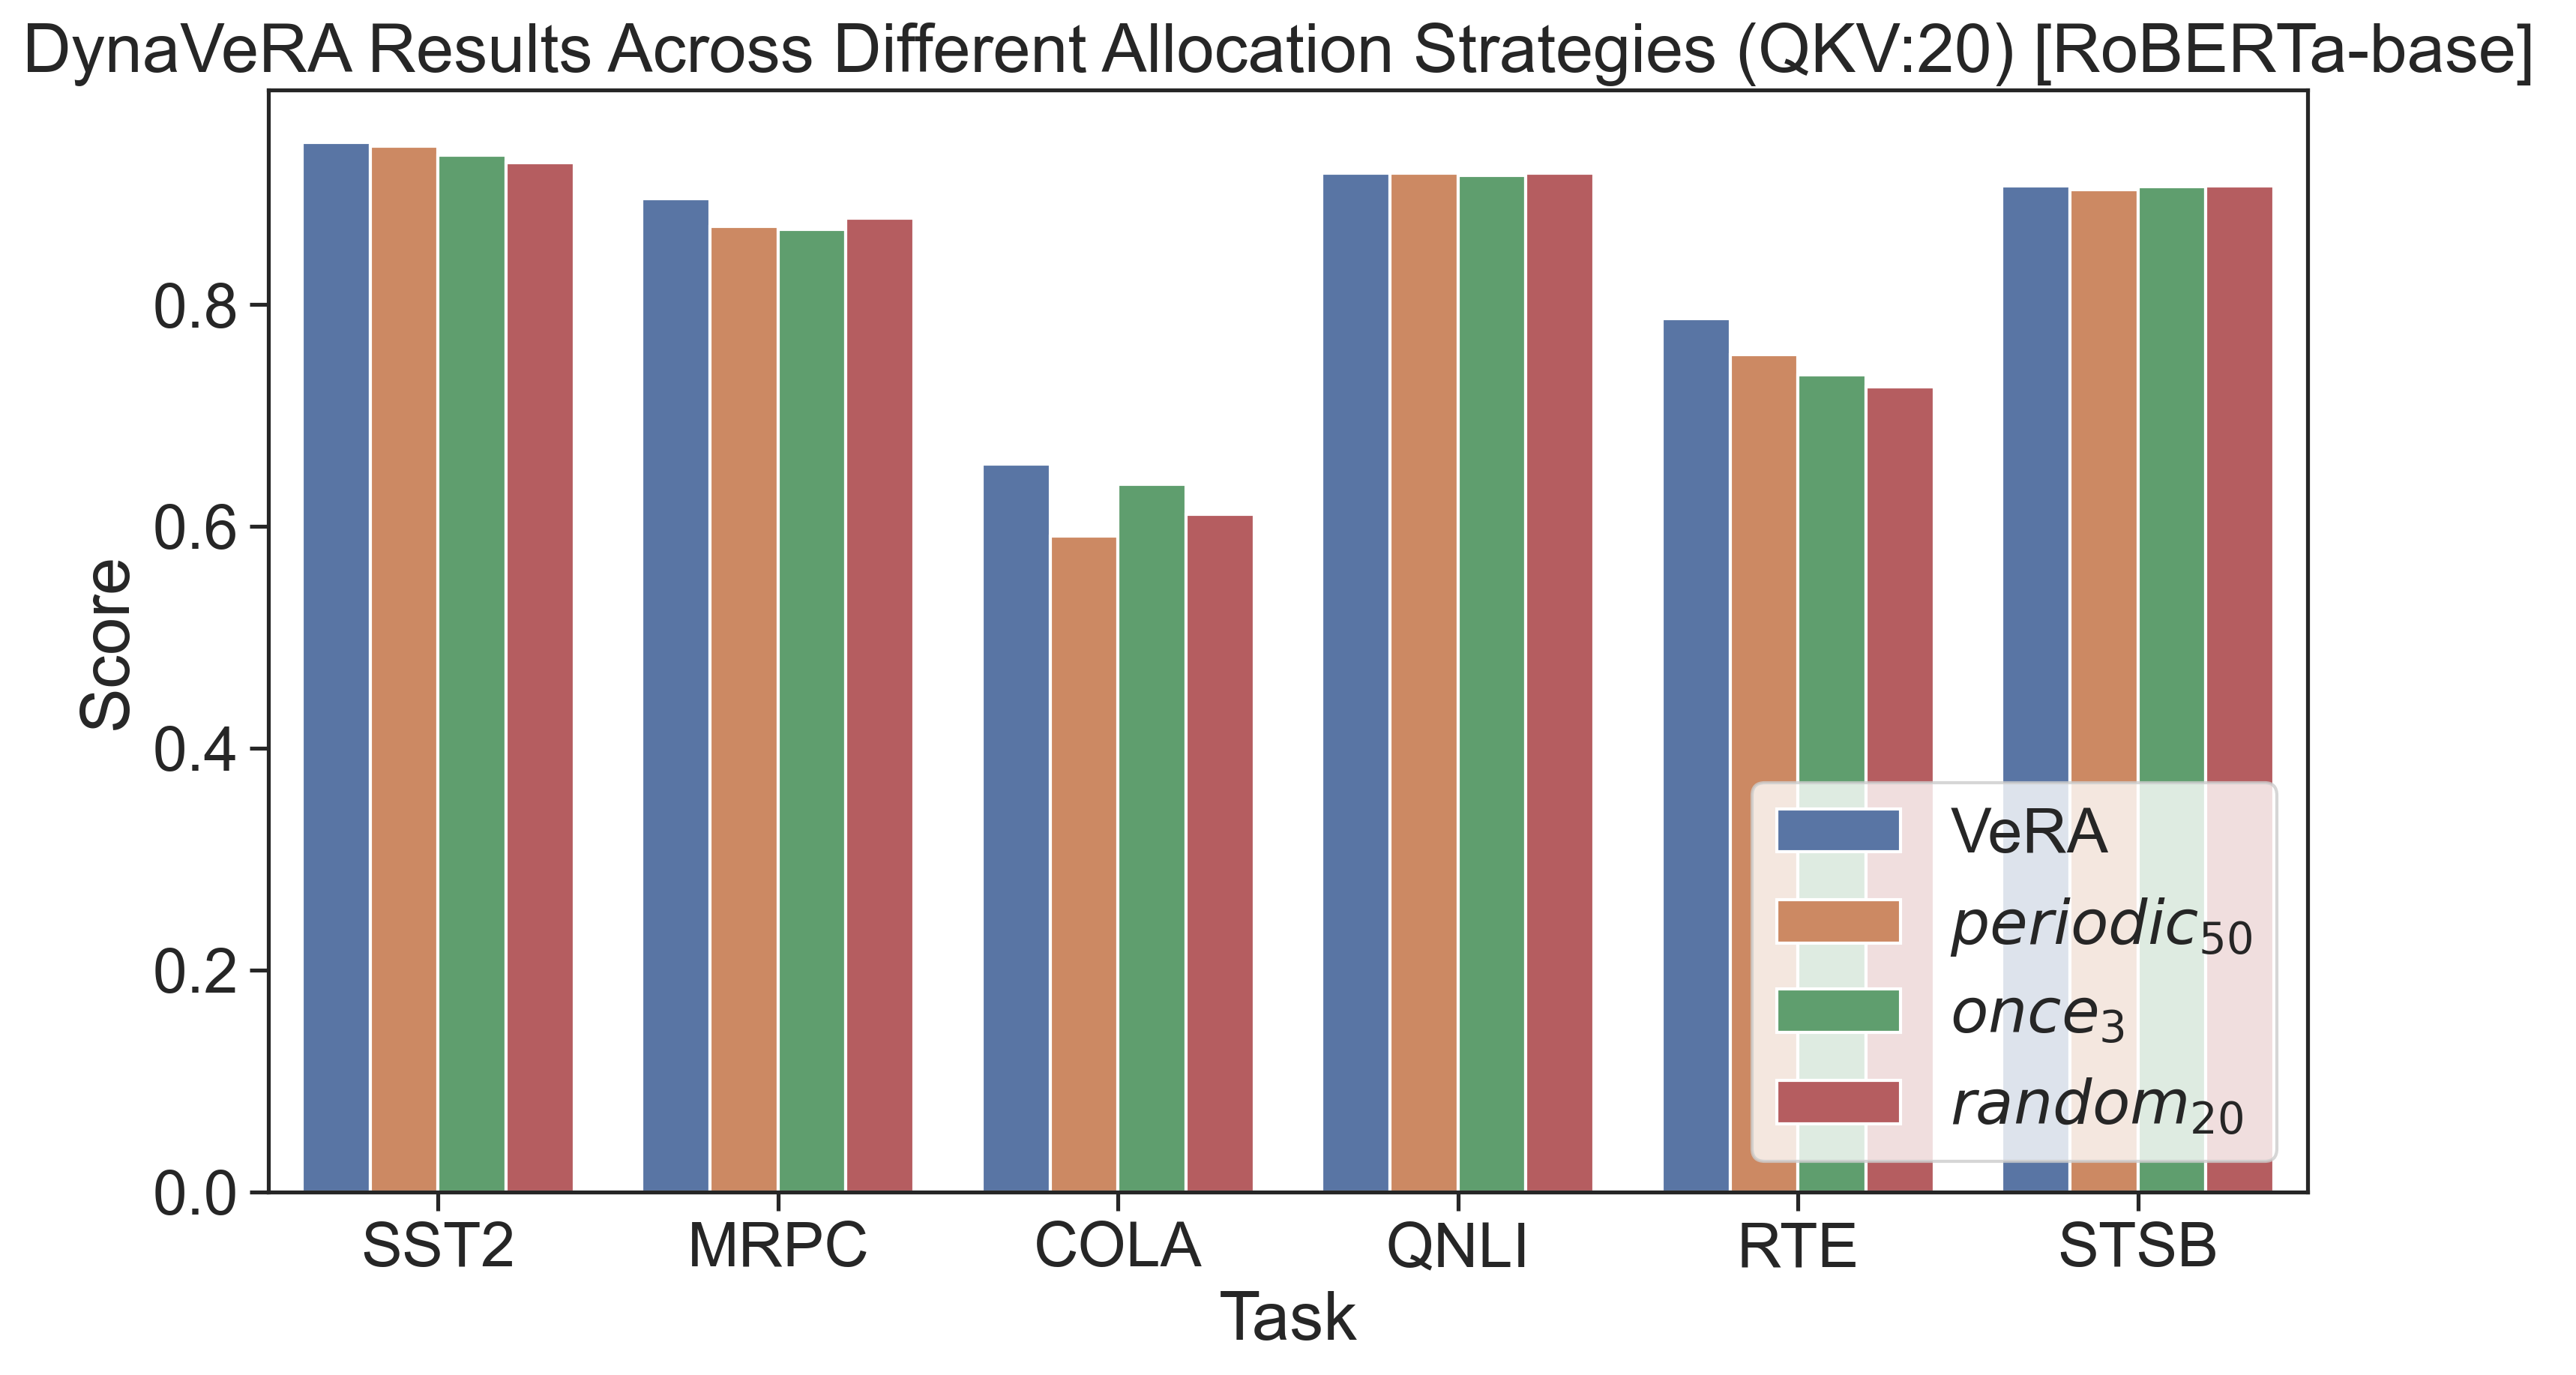

In [68]:
def create_barplot(
    data_dicts:list[dict],
    names:list[str],
    title:str
):
    get_results = lambda x: [x['sst2']['eval_accuracy'], x['mrpc']['eval_accuracy'],\
         x['cola']['eval_matthews_correlation'], x['qnli']['eval_accuracy'], \
            x['rte']['eval_accuracy'], x['stsb']['eval_pearson']]

    data = {name : get_results(data_dict) for name, data_dict in zip(names, data_dicts) }
    data.update({'Task' : [k.upper() for k in data_dicts[0].keys()]})
    df = pd.DataFrame(data)
    df_melted = df.melt(id_vars='Task', var_name='Result', value_name='Score')
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(x='Task', y='Score', hue='Result', data=df_melted)
    plt.title(title)
    plt.xlabel('Task')
    plt.ylabel('Score')
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()


create_barplot(
    data_dicts=[VeRA_paper, dynavera_periodic_qkv, dynavera_once_qkv, dynavera_random_qkv ],
    names=['VeRA',r'$periodic_{50}$', r'$once_{3}$', r'$random_{20}$'],
    title='DynaVeRA Results Across Different Allocation Strategies (QKV:20) [RoBERTa-base] '
    )


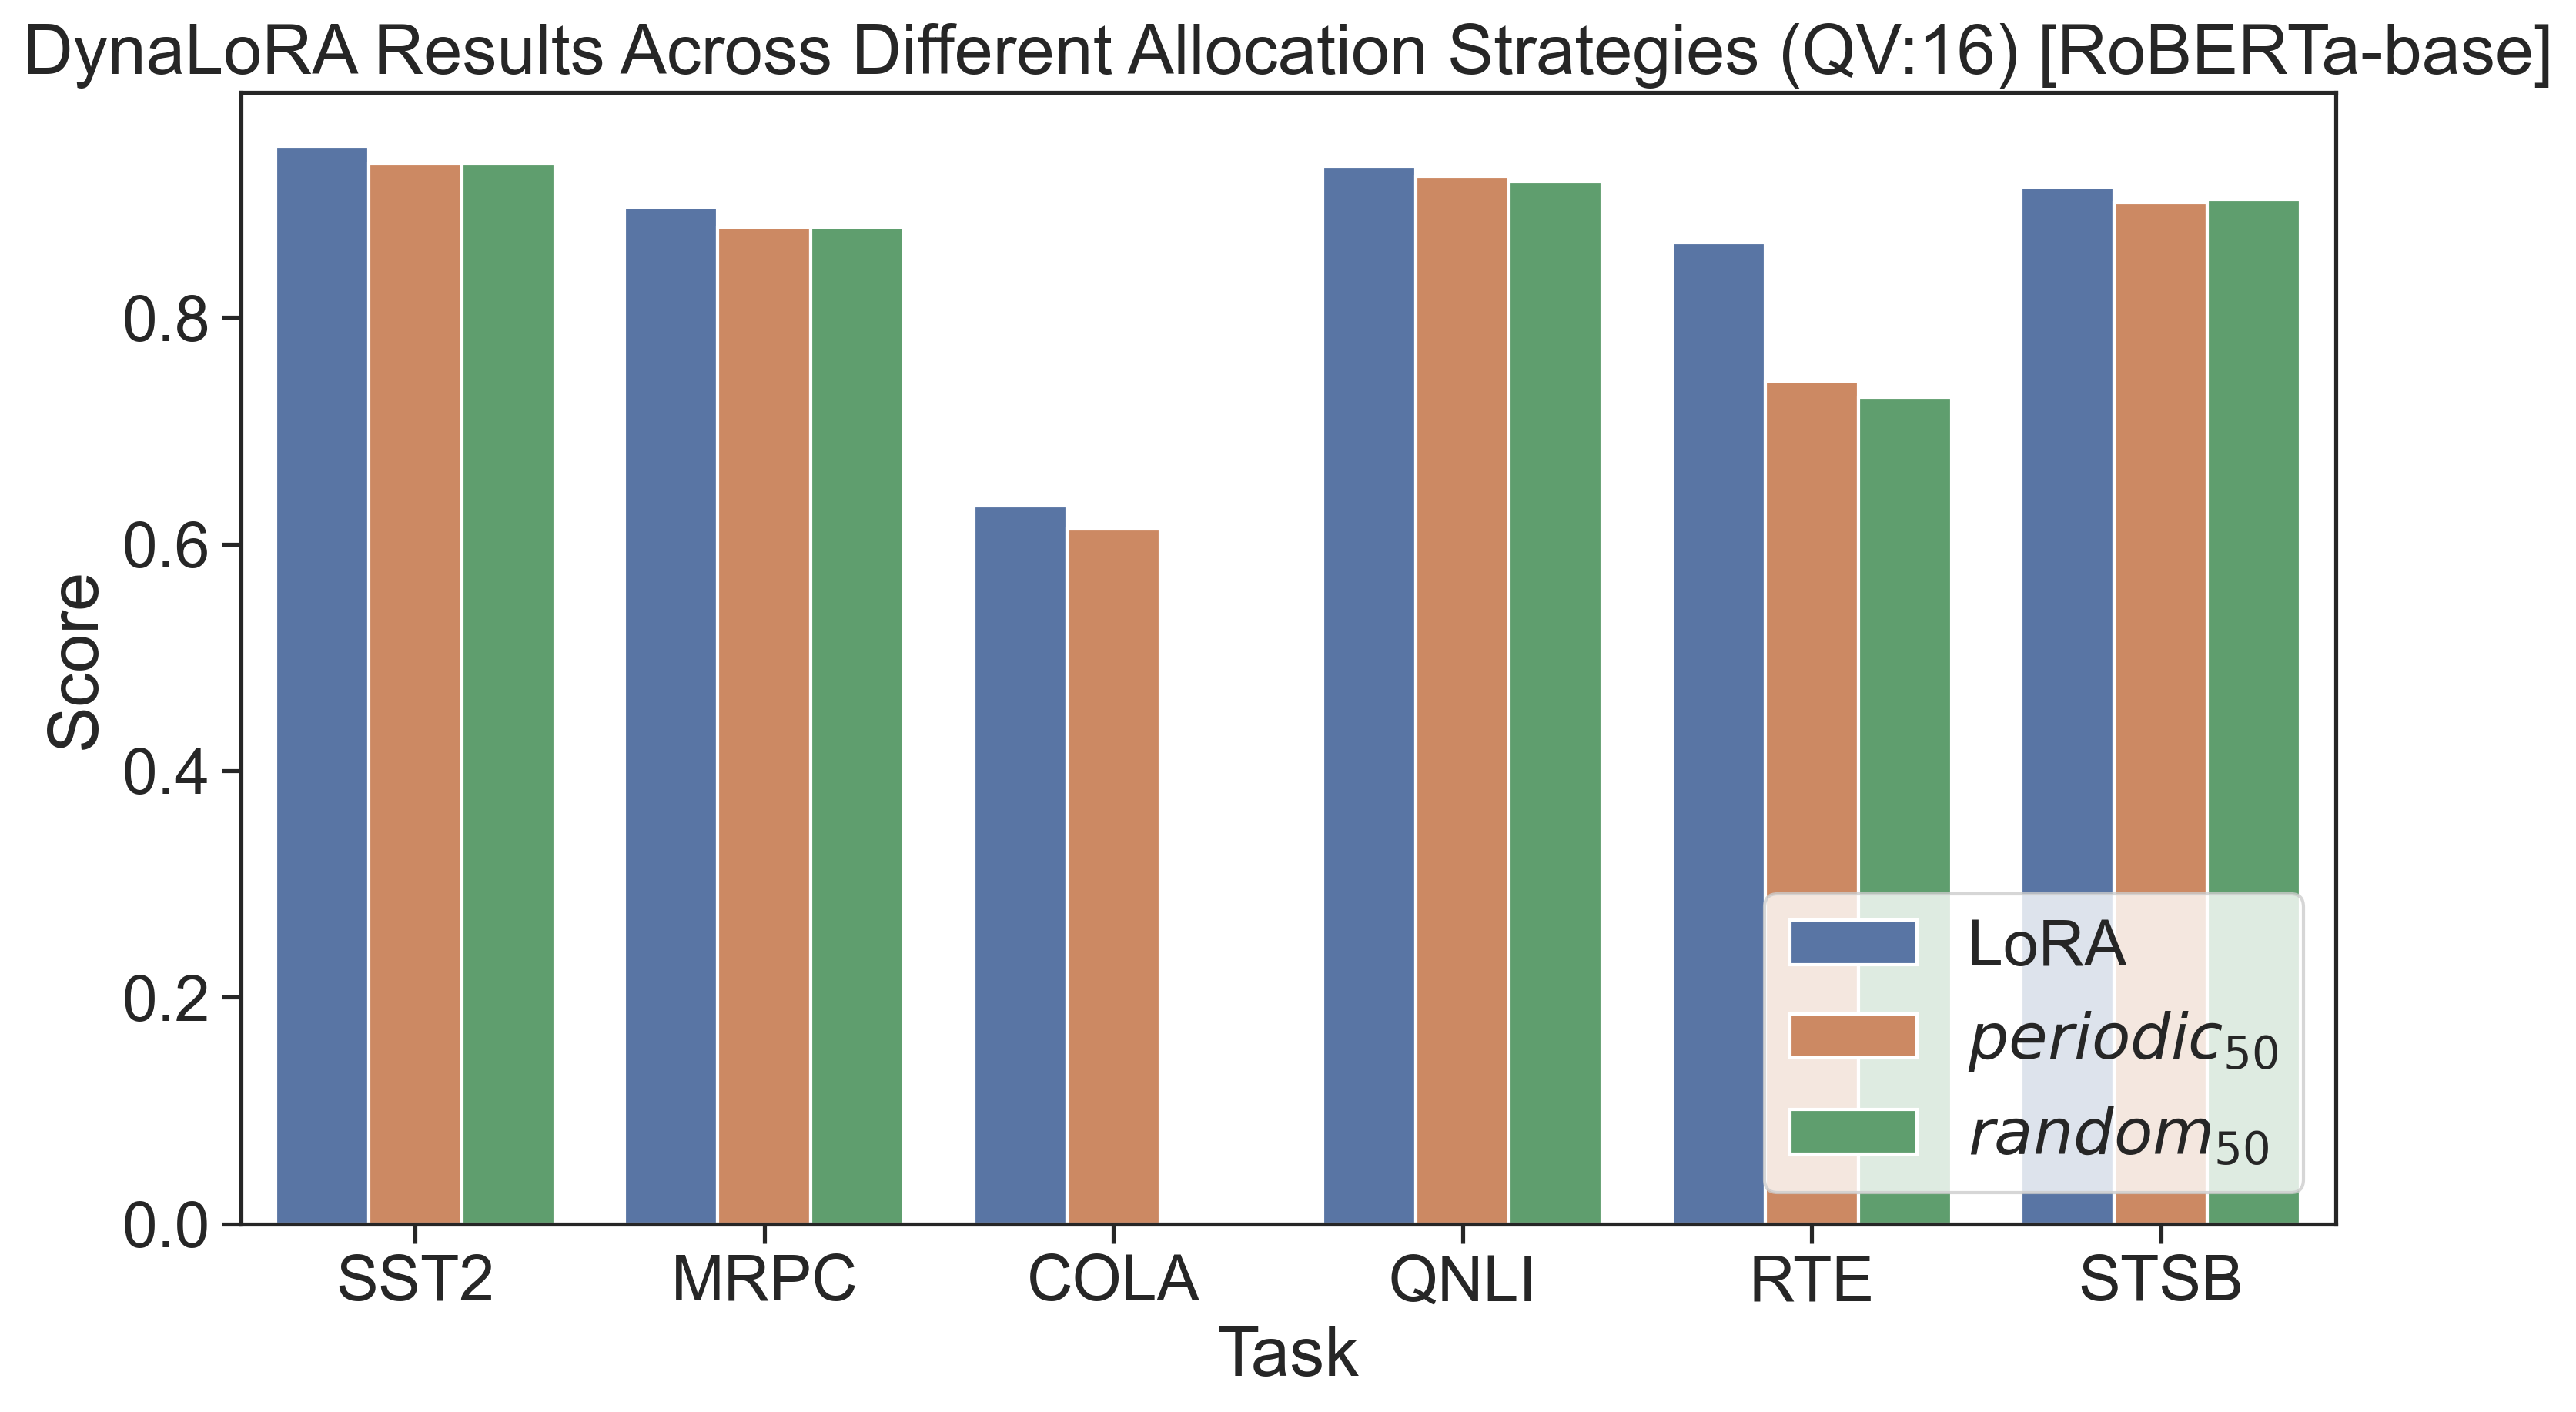

In [69]:
create_barplot(
    data_dicts=[LoRA_paper, dynalora_periodic_qv, dynalora_random_qv ],
    names=['LoRA', r'$periodic_{50}$', r'$random_{50}$'],
    title='DynaLoRA Results Across Different Allocation Strategies (QV:16) [RoBERTa-base]'
    )

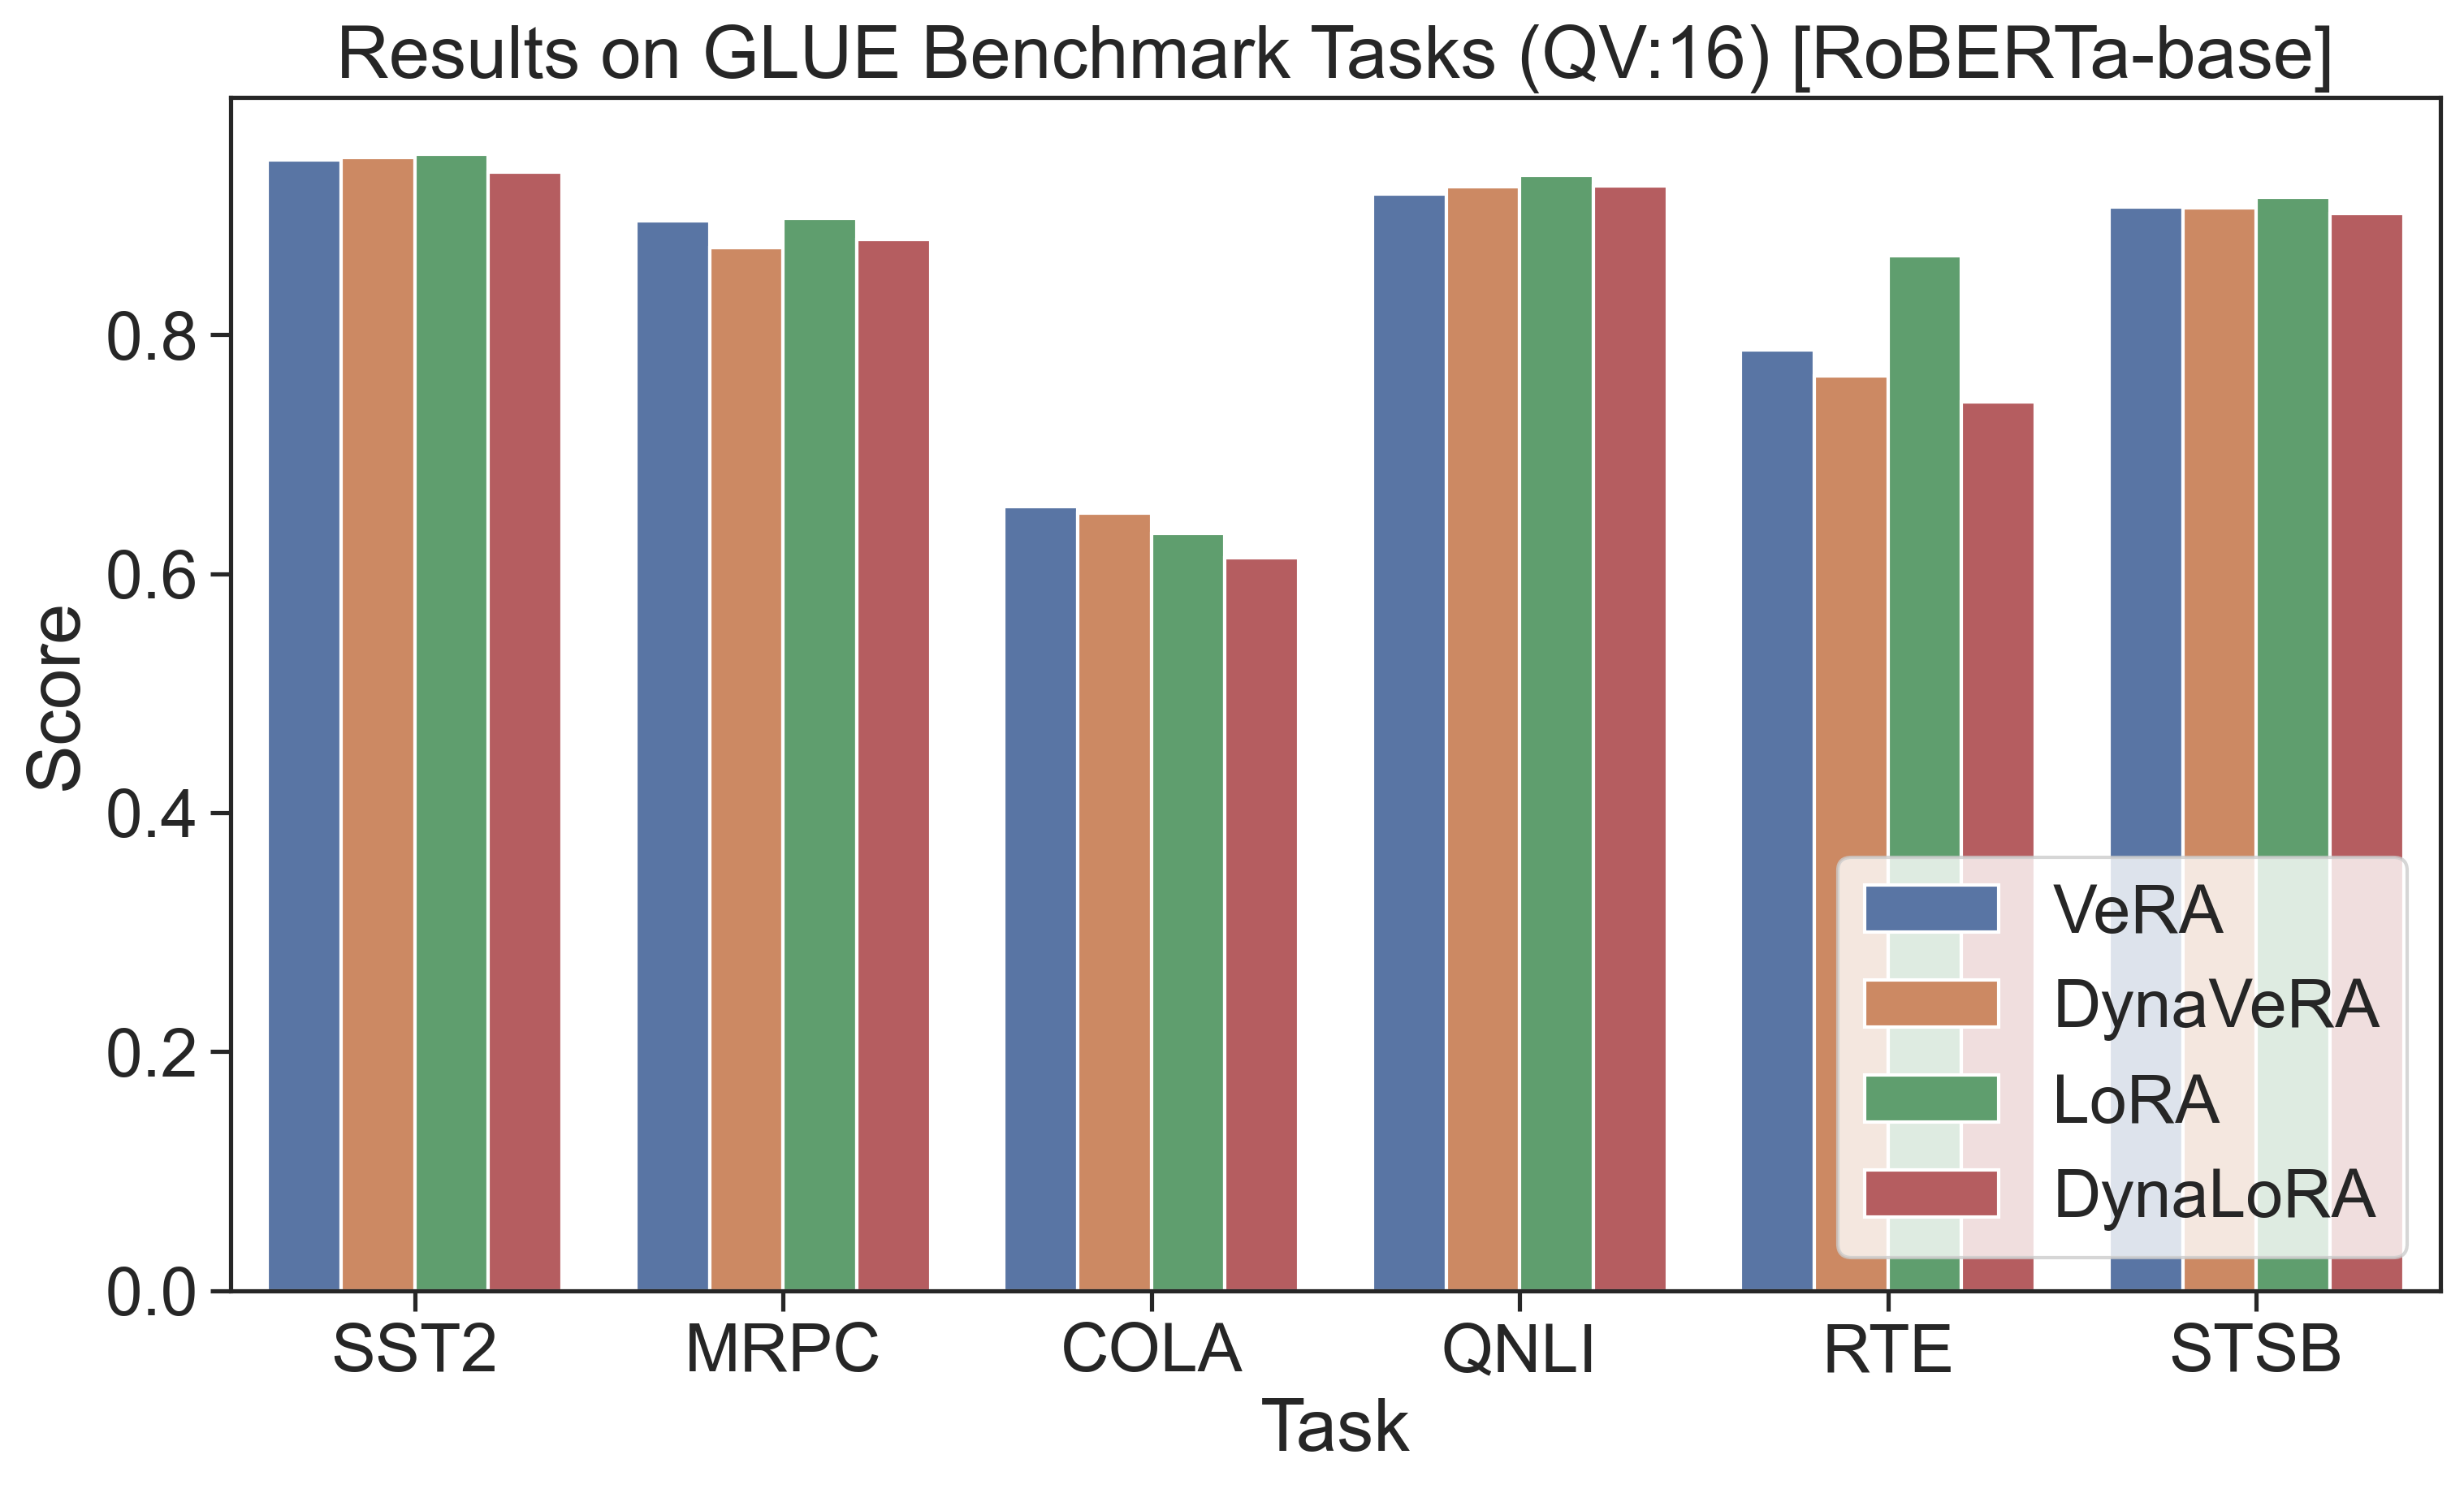

In [70]:
create_barplot(
    data_dicts=[VeRA_paper, dynavera_periodic_qv, LoRA_paper, dynalora_periodic_qv ],
    names=['VeRA', r'DynaVeRA', f'LoRA', r'DynaLoRA'],
    title='Results on GLUE Benchmark Tasks (QV:16) [RoBERTa-base]'
    )

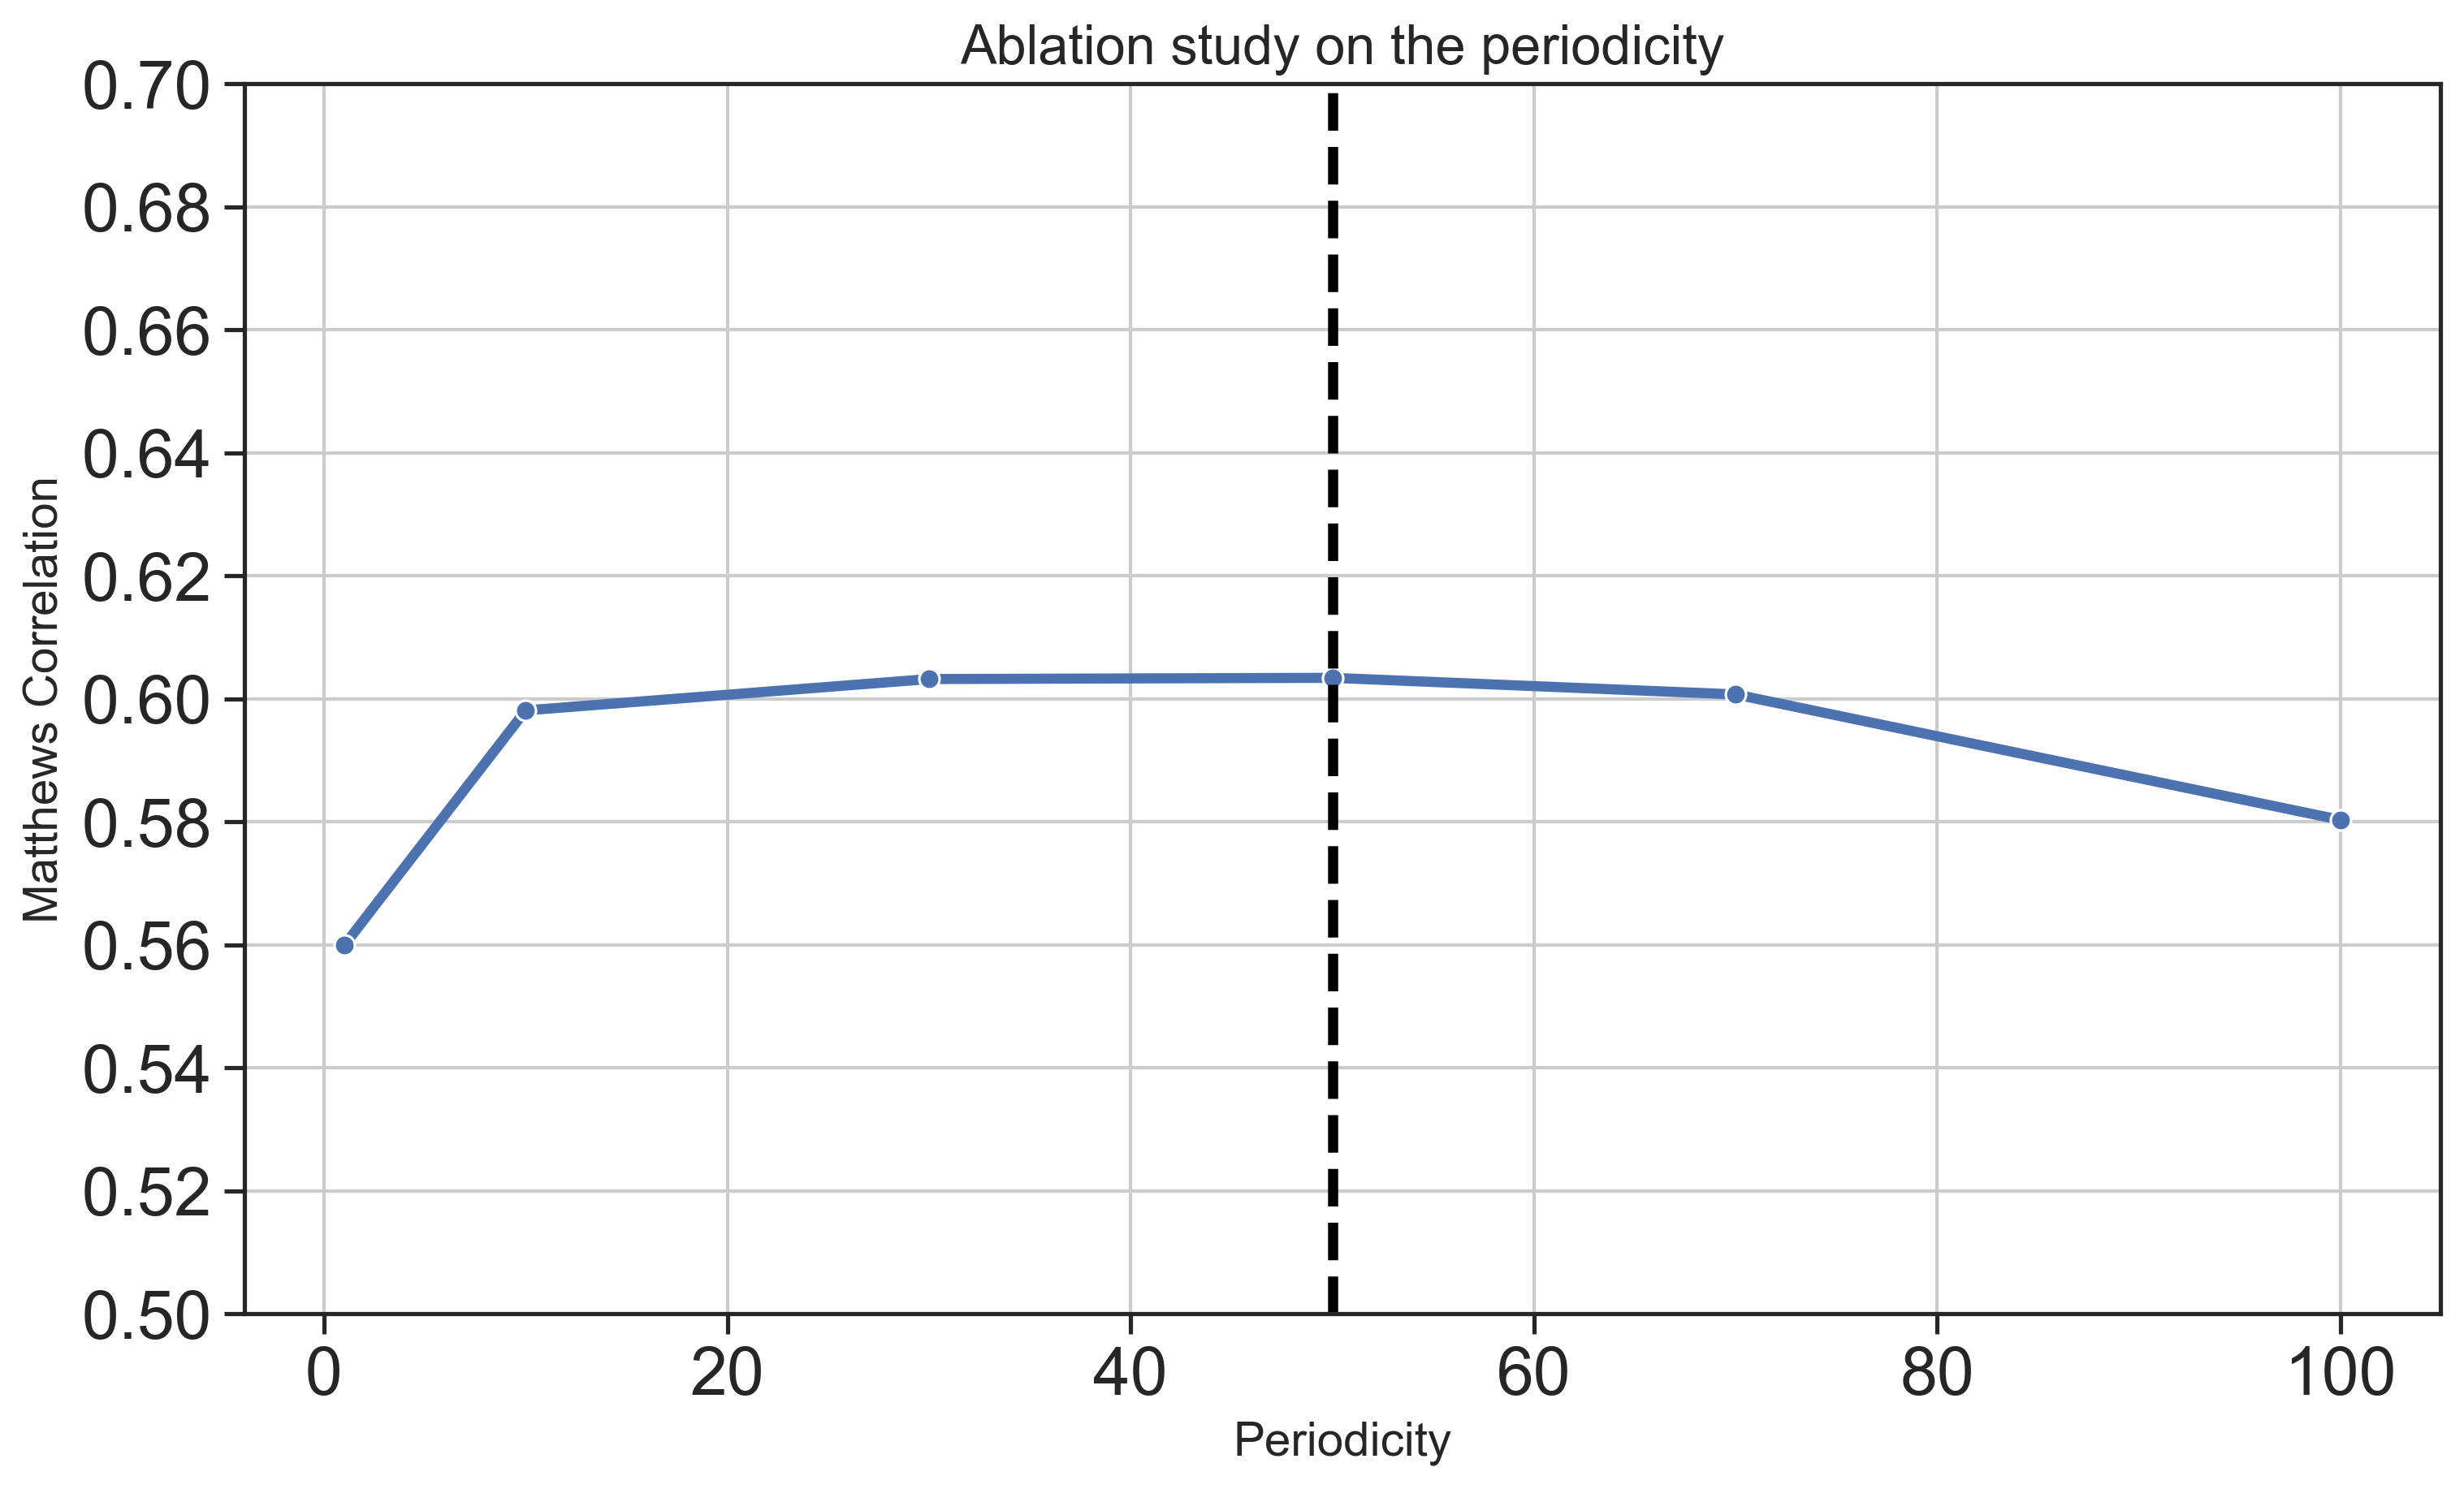

In [71]:
# Periodicity ablation DynaLoRA 
#  task=cola
# seed=42
# batch_size=32
# epochs=80
# learning_rate=4e-04
# warmup_ratio=0.06
# scaled_multinomial;12 

periodicity_results = {
    100 : 0.5803,
    70 : 0.6007,
    50 : 0.6034,
    30 : 0.6032,
    10 : 0.5981,
    1 : 0.5599
}

def plot_ablation(hyperparam_values:list, scores:list, x_label:str, y_label:str, title:str, range_score:tuple):
    data = {
        'hparam' : hyperparam_values,
        'score' : scores
    }
    df = pd.DataFrame(data)

    max_value = df['score'].max()
    max_index = df['score'].idxmax()
    max_hyperparameter = df['hparam'][max_index]

    plt.figure(figsize=(10, 6))
    plot = sns.lineplot(data=df, x='hparam', y='score', marker='o')
    plot.set_title(title, fontsize=16)
    plot.set_xlabel(x_label, fontsize=14)
    plot.set_ylabel(y_label, fontsize=14)
    # plot.set_xticks(df['Periodicity'])
    plot.set_yticks(np.linspace(range_score[0], range_score[1], 11))
    plot.grid(True)

    plot.axvline(x=max_hyperparameter, ls='--', color='black')

    # Show the plot
    plt.show()

plot_ablation(
    periodicity_results.keys(),
    periodicity_results.values(),
    'Periodicity',
    'Matthews Correlation',
    'Ablation study on the periodicity',
    range_score=(0.5, 0.7)
)
